In [3]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
with open("assignments.pkl", 'r') as picklefile: 
    assignments = pickle.load(picklefile)
ids_with_jobs = assignments["ciphertext"].unique()

In [5]:
hourly_with_payment = assignments[(pd.isnull(assignments["as_total_charge"]) == False) & (assignments["as_job_type"] == "Hourly") & (assignments["as_total_hours_precise"] != "0")]
hourly_without_payment = assignments[((pd.isnull(assignments["as_total_charge"]) == True) | (assignments["as_total_hours_precise"] == "0")) & (assignments["as_job_type"] == "Hourly")]
count_assignments_np = hourly_without_payment[["ciphertext", "as_opening_title"]].groupby("ciphertext").agg('count').reset_index()
count_assignments_p = hourly_with_payment[["ciphertext", "as_opening_title"]].groupby("ciphertext").agg('count').reset_index()
count_assignments_np.columns = ["ciphertext", "assignments_not_paid"]
count_assignments_p.columns = ["ciphertext", "assignments_paid"]
# ciphertext, num assignments no payment info, num assignments payment info 

In [6]:
merged_count = count_assignments_p.merge(count_assignments_np, how = "outer", on = "ciphertext")

In [7]:
len(merged_count)
# have 14,000 people or so 

14053

In [8]:
merged_count = merged_count.fillna(value = 0)

In [9]:
never_had_payment_info = merged_count[merged_count["assignments_paid"] == 0]
always_had_payment_info = merged_count[merged_count["assignments_not_paid"] == 0]
had_both_types = len(merged_count) - len(never_had_payment_info) - len(always_had_payment_info)
print "%d freelancers always had payment information" %len(always_had_payment_info)
print "%d freelancers never had payment information" %len(never_had_payment_info)
print "%d freelancers had both types of public payment and private" %had_both_types

4113 freelancers always had payment information
2719 freelancers never had payment information
7221 freelancers had both types of public payment and private


In [10]:
from pymongo import MongoClient
client = MongoClient()
db = client.data_scientist_profiles

In [11]:
ids_with_jobs = ids_with_jobs.tolist()
cursor = db.final_profile_details.find({"ciphertext": { "$in": ids_with_jobs}}, {"dev_bill_rate": 1,
                                        "ciphertext" : 1, "dev_profile_title": 1, 
                                        "dev_country": 1})
profiles_billing =  pd.DataFrame(list(cursor))

In [12]:
profiles_billing.head()

,_id,ciphertext,dev_bill_rate,dev_country,dev_profile_title
0,57c488aa97f6b341e8728c4d,~01d3ad50155896e4ae,35.00,Ireland,Data Science and Statistics Consultant | Pytho...
1,57c4890097f6b341e8728c4e,~01d3ad50155896e4ae,35.00,Ireland,Data Science and Statistics Consultant | Pytho...
2,57c4890297f6b341e8728c51,~0199f1742b3c7202ba,18.00,United States,Data Science Analytic
3,57c4890397f6b341e8728c52,~010ee721f96dbeb744,8.00,India,"Analytics Consulting, Data Science"
4,57c4890397f6b341e8728c53,~0113b7a1ad10ba8634,25.00,United States,Data science & statistical computing


### Billing Rates by Country

In [52]:
print "Freelancers come from %d countries" %len(profiles_billing.groupby(["dev_country"]))

Freelancers come from 156 countries


In [89]:
profiles_billing["dev_bill_rate"] = profiles_billing["dev_bill_rate"].apply(lambda x: float(x))
country_count = profiles_billing[["_id", "dev_country"]].groupby(["dev_country"]).agg("count").reset_index()
country_count.columns = ["Country", "Num_of_Freelancers"]
popular_countries = country_count[country_count["Num_of_Freelancers"] > 175]
profiles_billing_pop_countries = profiles_billing[profiles_billing["dev_country"].isin(popular_countries["Country"])]
mean_dev_rate = profiles_billing_pop_countries[["dev_bill_rate", "dev_country"]].groupby("dev_country").mean().reset_index()
mean_dev_rate.sort_values("dev_bill_rate", inplace = True)

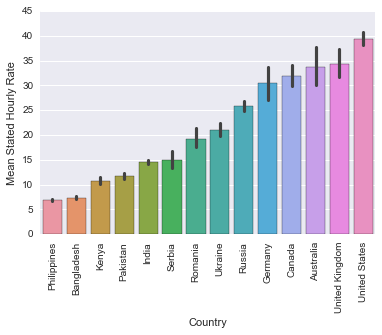

In [187]:
g = sns.barplot(x = "dev_country", y = "dev_bill_rate", data = profiles_billing_pop_countries, 
               order = mean_dev_rate["dev_country"])
plt.xticks(rotation=90)
g.set(xlabel = "Country", ylabel = "Mean Stated Hourly Rate")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

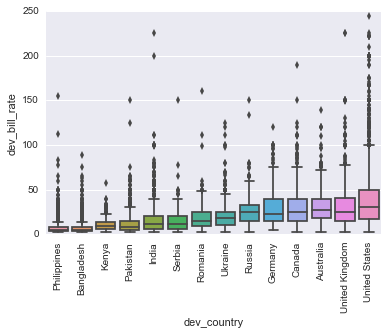

In [95]:
profiles_billing_pop_countries_no_out = profiles_billing_pop_countries[profiles_billing_pop_countries["dev_bill_rate"] < 250]
sns.boxplot(x = "dev_country", y = "dev_bill_rate", data = profiles_billing_pop_countries_no_out, order = mean_dev_rate["dev_country"])
plt.xticks(rotation=90)


## Billing Rates by Country only those who have done DS jobs

In [13]:
data_science_terms = ["(?i)data", "(?i)research", "(?i)entry", "(?i)excel", "(?i)web",
                     "(?i)developer", "(?i)database", "(?i)researcher", "(?i)spreadsheet", 
                     "(?i)scrap", "(?i)php", "(?i)python", "(?i)STATA", "(?i)SPSS", "(?i)SQL", 
                     "(?i)MATLAB", "(?i)study", "(?i)survey", "(?i)statis", "(?i)probability", 
                     "(?i)analy", "(?i)optimiz", "(?i)hadoop", "(?i)spark", "(?i)file", 
                     "(?i)machine", "(?i) R ", "(?i)science", "(?i)csv", "(?i)d3", "(?i)Visualiz", 
                     "(?i)mining", "(i?)java", "(?i)scrape", "(?i)quant", "(?i)model", "(?i)github",
                     "(?i)api ", "(?i)code", "(?i)program", "(?i)json", "(?i)automat", "(?i)devel", 
                     "(?i)search", "(?i)forecasting", "(?i)\[R\]", "(?i)calcul", "(?i)script", 
                     "(?i)processi", "(?i)classif", "(?i)simulat", "(?i)math", "(?i)algorit", 
                     "(?i)Probabil", "(?i)Predict"]

In [14]:
# Make a regex that matches if any of our regexes match.
combined_data_science_terms = "(" + ")|(".join(data_science_terms) + ")"
data_science_job = assignments["as_opening_title"].apply(lambda x: 1 if re.search(combined_data_science_terms, x) else 0)
sum(data_science_job)

122359

In [15]:
assignments["ds_job"] = data_science_job
ds_jobs = assignments[assignments["ds_job"] == 1]
people_with_ds_jobs = ds_jobs["ciphertext"].unique()

In [22]:
ds_jobs_limited = ds_jobs[["ciphertext", "as_opening_title"]]
ds_jobs_limited["as_opening_title"] = ds_jobs_limited["as_opening_title"].apply(lambda x: x.encode('ascii', 'ignore'))
pd.DataFrame.to_csv(ds_jobs_limited, "ds_job_titles.csv")

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [20]:
ds_jobs.head()

,as_agency_name,as_ciphertext_opening_recno,as_financial_privacy,as_from_full,as_job_type,as_opening_title,as_rate,as_to,as_to_full,as_total_charge,as_total_hours,as_total_hours_precise,ciphertext,ds_job
6,NaN,NaN,NaN,NaN,Fixed,Data Mining Research Project (1/3) Completed,$0.00,08/2016,08/12/2016,220,0.00,0,~01d3ad50155896e4ae,1
7,NaN,NaN,NaN,NaN,Fixed,STATA help- regression,$0.00,07/2016,07/25/2016,60,0.00,0,~01d3ad50155896e4ae,1
8,NaN,NaN,NaN,NaN,Fixed,Simple Python Programming,$0.00,07/2016,07/18/2016,50,0.00,0,~01d3ad50155896e4ae,1
9,NaN,NaN,NaN,NaN,Fixed,Forecasting - ARIMAX [R],None,07/2016,07/07/2016,None,0.00,0,~01d3ad50155896e4ae,1
10,NaN,NaN,NaN,NaN,Fixed,Statistical analysis for study with 116 partic...,None,06/2016,06/12/2016,None,0.00,0,~01d3ad50155896e4ae,1


In [16]:
len(people_with_ds_jobs)

15591

In [19]:
with open('people_with_ds_jobs.pkl', 'w') as picklefile:
    pickle.dump(people_with_ds_jobs, picklefile)

In [100]:
profiles_billing_ds = profiles_billing[profiles_billing["ciphertext"].isin(people_with_ds_jobs)]
country_count_ds = profiles_billing_ds[["_id", "dev_country"]].groupby(["dev_country"]).agg("count").reset_index()
country_count_ds.columns = ["Country", "Num_of_Freelancers"]
popular_countries_ds = country_count_ds[country_count_ds["Num_of_Freelancers"] > 175]
profiles_billing_pop_countries_ds = profiles_billing_ds[profiles_billing_ds["dev_country"].isin(popular_countries_ds["Country"])]
mean_dev_rate_ds = profiles_billing_pop_countries_ds[["dev_bill_rate", "dev_country"]].groupby("dev_country").mean().reset_index()
mean_dev_rate_ds.sort_values("dev_bill_rate", inplace = True)

[<matplotlib.text.Text at 0x136f44710>, <matplotlib.text.Text at 0x11d788410>]

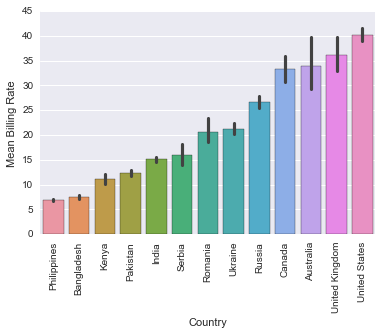

In [104]:
g = sns.barplot(x = "dev_country", y = "dev_bill_rate", data = profiles_billing_pop_countries_ds, 
               order = mean_dev_rate_ds["dev_country"])
plt.xticks(rotation=90)
g.set(xlabel = "Country", ylabel = "Mean Hourly  Rate")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

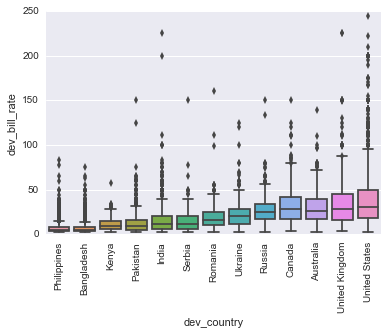

In [117]:
profiles_billing_pop_countries_no_out_ds = profiles_billing_pop_countries_ds[profiles_billing_pop_countries_ds["dev_bill_rate"] < 250]
sns.boxplot(x = "dev_country", y = "dev_bill_rate", data = profiles_billing_pop_countries_no_out_ds, order = mean_dev_rate_ds["dev_country"])
plt.xticks(rotation=90)


## Actual Assignment Payment by Country

### Fixed assignments, only data science, only popular countries

In [132]:
# add on country to assignments dataset
dev_country = profiles_billing[["ciphertext", "dev_country"]]
assignments_with_country = assignments.merge(dev_country, how = "left", on = "ciphertext")

In [142]:
assignments_with_country_ds = assignments_with_country[assignments_with_country["ds_job"] == 1]
fixed_ds_coun = assignments_with_country_ds[assignments_with_country_ds["as_job_type"] == "Fixed"]
fixed_ds_coun["as_total_charge"] = fixed_ds_coun["as_total_charge"].apply(lambda x: float(x) if pd.isnull(x) == False else x)
# only want popular countries
fixed_ds_coun = fixed_ds_coun[fixed_ds_coun["dev_country"].isin(popular_countries_ds["Country"])]
mean_fixed_rate_ds = fixed_ds_coun[["as_total_charge", "dev_country"]].groupby("dev_country").mean().reset_index()
mean_fixed_rate_ds.sort_values("as_total_charge", inplace = True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


[<matplotlib.text.Text at 0x13d9951d0>, <matplotlib.text.Text at 0x13d97e350>]

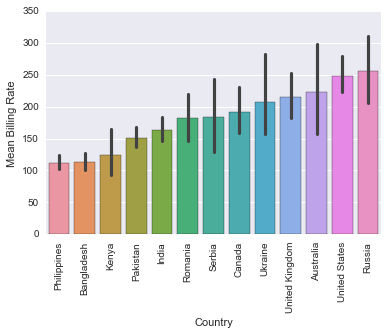

In [149]:
g = sns.barplot(x = "dev_country", y = "as_total_charge", data = fixed_ds_coun,
                order = mean_fixed_rate_ds["dev_country"])
plt.xticks(rotation=90)
g.set(xlabel = "Country", ylabel = "Mean Billing Rate")

### Country count for all freelancers

In [259]:
cursor = db.final_profile_details.find({}, {"dev_country": 1, "ciphertext": 1})
country_df =  pd.DataFrame(list(cursor))

In [269]:
country_count_all = country_df.groupby(["dev_country"]).agg("count").reset_index()
del country_count_all["_id"]
country_count_all.columns = ["Country", "Num_of_Freelancers"]
country_count_all = country_count_all.sort_values(by = "Num_of_Freelancers", ascending = False)
print len(country_count_all)
country_count_all.head(10)


193


,Country,Num_of_Freelancers
182,United States,20570
78,India,18323
137,Philippines,10252
130,Pakistan,5823
15,Bangladesh,5110
181,United Kingdom,2569
33,Canada,2448
144,Russia,1965
89,Kenya,1903
179,Ukraine,1868


### Hourly assignments, only data science, only popular countries

In [151]:
ds_jobs = assignments_with_country[assignments_with_country["ds_job"] == 1]
ds_hourly_with_payment = ds_jobs[(pd.isnull(ds_jobs["as_total_charge"]) == False) & (ds_jobs["as_job_type"] == "Hourly")]
ds_per_hourly_with_payment = float(len(ds_hourly_with_payment))/len(ds_jobs[ds_jobs["as_job_type"] == "Hourly"])
ds_per_hourly_with_payment = "%.2f" %ds_per_hourly_with_payment
ds_hourly_with_payment["as_total_charge"] = ds_hourly_with_payment["as_total_charge"].apply(lambda x: float(x))
ds_hourly_with_payment["as_total_hours_precise"] = ds_hourly_with_payment["as_total_hours_precise"].apply(lambda x: float(x))
ds_hourly_with_payment["as_total_charge"] = ds_hourly_with_payment["as_total_charge"].apply(lambda x: float(x))
ds_hourly_with_payment_hours = ds_hourly_with_payment[ds_hourly_with_payment["as_total_hours_precise"] != 0]
ds_hourly_with_payment_hours["real_rate"] = ds_hourly_with_payment_hours["as_total_charge"]/ds_hourly_with_payment_hours["as_total_hours_precise"]
ds_hourly_with_payment_hours["as_rate"] = ds_hourly_with_payment_hours["as_rate"].apply(lambda x: x.replace("$", ""))
ds_hourly_with_payment_hours["as_rate"] = ds_hourly_with_payment_hours["as_rate"].apply(lambda x: float(x))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

In [156]:
ds_hourly_with_payment_hours = ds_hourly_with_payment_hours[ds_hourly_with_payment_hours["dev_country"].isin(popular_countries_ds["Country"])]
mean_hourly_rate_ds = ds_hourly_with_payment_hours[["real_rate", "dev_country"]].groupby("dev_country").mean().reset_index()
mean_hourly_rate_ds.sort_values("real_rate", inplace = True)

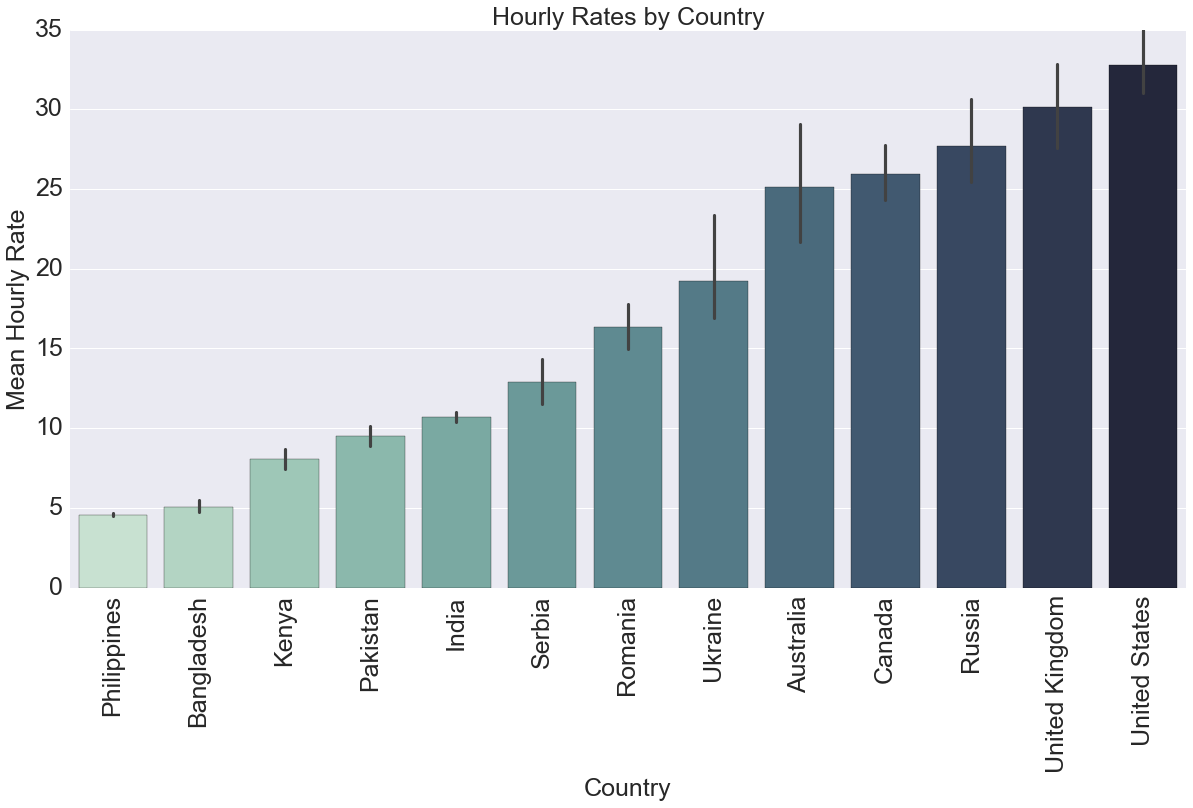

In [253]:
rc={'xtick.labelsize': 25, 'ytick.labelsize': 25, 'axes.labelsize': 25, 'font.size': 25, 'legend.fontsize': 25.0, 'axes.titlesize': 25, "figure.figsize": [20, 10]}
sns.set(rc)
#sns.set_palette(sns.light_palette("green", n_colors = 14))
sns.set_palette(sns.cubehelix_palette(13, start=.1, rot=-.4))
g = sns.barplot(x = "dev_country", y = "real_rate", data = ds_hourly_with_payment_hours,
                order = mean_hourly_rate_ds["dev_country"])
plt.xticks(rotation=90)
g.set(xlabel = "Country", ylabel = "Mean Hourly Rate", title = "Hourly Rates by Country")
#plt.savefig("hourly_rate_country.png", bbox_inches='tight', dpi = 115)

## Actual Billing Rates by Education

In [158]:
with open("highest_degree.pkl", 'r') as picklefile: 
    highest_degree = pickle.load(picklefile)

In [159]:
assignments_with_education = assignments_with_country.merge(highest_degree, how = "left")

#### Number of degrees for whole population

In [279]:
len(profiles_billing)

21603

In [278]:
highest_degree_count_all = highest_degree.groupby(["degrees_ranked"]).agg("count").reset_index()
highest_degree_count_all.columns = ["Degree", "Num_of_Freelancers"]
highest_degree_count_all
#popular_countries_ds = country_count_ds[country_count_ds["Num_of_Freelancers"] > 175]

,Degree,Num_of_Freelancers
0,,10834
1,Associates,1025
2,Bachelors,35995
3,High School,1110
4,JD,60
5,MBA,62
6,MD,153
7,Masters,26071
8,PhD,3619
9,other,931


In [164]:
ds_jobs = assignments_with_education[assignments_with_education["ds_job"] == 1]
ds_hourly_with_payment = ds_jobs[(pd.isnull(ds_jobs["as_total_charge"]) == False) & (ds_jobs["as_job_type"] == "Hourly")]
ds_per_hourly_with_payment = float(len(ds_hourly_with_payment))/len(ds_jobs[ds_jobs["as_job_type"] == "Hourly"])
ds_per_hourly_with_payment = "%.2f" %ds_per_hourly_with_payment
ds_hourly_with_payment["as_total_charge"] = ds_hourly_with_payment["as_total_charge"].apply(lambda x: float(x))
ds_hourly_with_payment["as_total_hours_precise"] = ds_hourly_with_payment["as_total_hours_precise"].apply(lambda x: float(x))
ds_hourly_with_payment["as_total_charge"] = ds_hourly_with_payment["as_total_charge"].apply(lambda x: float(x))
ds_hourly_with_payment_hours = ds_hourly_with_payment[ds_hourly_with_payment["as_total_hours_precise"] != 0]
ds_hourly_with_payment_hours["real_rate"] = ds_hourly_with_payment_hours["as_total_charge"]/ds_hourly_with_payment_hours["as_total_hours_precise"]
ds_hourly_with_payment_hours["as_rate"] = ds_hourly_with_payment_hours["as_rate"].apply(lambda x: x.replace("$", ""))
ds_hourly_with_payment_hours["as_rate"] = ds_hourly_with_payment_hours["as_rate"].apply(lambda x: float(x))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

In [167]:
mean_hourly_rate_ds_ed = ds_hourly_with_payment_hours[["real_rate", "degrees_ranked"]].groupby("degrees_ranked").mean().reset_index()
mean_hourly_rate_ds_ed.sort_values("real_rate", inplace = True)

In [191]:
mean_hourly_without_d = without_non_degrees[["real_rate", "degrees_ranked"]].groupby("degrees_ranked").mean().reset_index()
mean_hourly_without_d .sort_values("real_rate", inplace = True)

In [195]:
highest_degree_count = ds_hourly_with_payment_hours[["ciphertext", "degrees_ranked"]].groupby(["degrees_ranked"]).agg("count").reset_index()
highest_degree_count.columns = ["Degree", "Num_of_Freelancers"]
highest_degree_count
#popular_countries_ds = country_count_ds[country_count_ds["Num_of_Freelancers"] > 175]

,Degree,Num_of_Freelancers
0,,1741
1,Associates,281
2,Bachelors,18688
3,High School,925
4,JD,6
5,MBA,22
6,MD,13
7,Masters,10814
8,PhD,1047
9,other,522


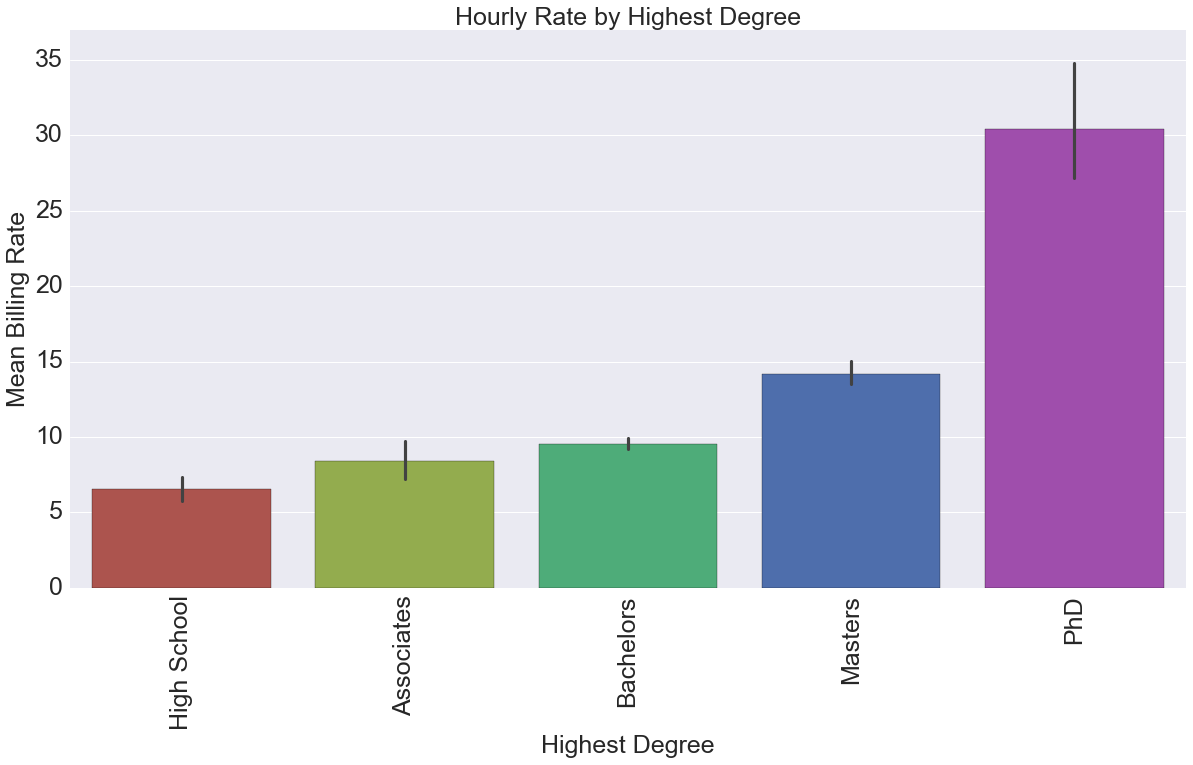

In [249]:
without_non_degrees = ds_hourly_with_payment_hours[ds_hourly_with_payment_hours["degrees_ranked"].isin(["High School", "Associates", "Bachelors", "Masters", "PhD"])]
sns.set_palette(sns.hls_palette(5, l=.49, s=.5))
g = sns.barplot(x = "degrees_ranked", y = "real_rate", data = without_non_degrees,
                order = mean_hourly_without_d["degrees_ranked"])
plt.xticks(rotation=90)
plt.ylim(0, 37)
g.set(xlabel = "Highest Degree", ylabel = "Mean Billing Rate", title = "Hourly Rate by Highest Degree")
plt.savefig("hourly_rate_education.png", bbox_inches='tight', dpi = 115)

## Look for bias whether job information public: are people with higher rates listed less likely to disclose job rates?

In [169]:
always_had_payment_info.head()

,ciphertext,assignments_paid,assignments_not_paid
0,~010008b64f761401e8,1.0,0.0
4,~0100173b4909683674,1.0,0.0
6,~010019bdf5dae46b32,2.0,0.0
9,~0100215bc55f405db5,7.0,0.0
11,~0100436fc8138df378,1.0,0.0


In [172]:
prof_never_payment_info = never_had_payment_info["ciphertext"]
prof_always_payment_info = always_had_payment_info["ciphertext"]

In [179]:
profiles_always_payment_info = profiles_billing[profiles_billing["ciphertext"].isin(prof_always_payment_info)]
profiles_never_payment_info = profiles_billing[profiles_billing["ciphertext"].isin(prof_never_payment_info)]

In [185]:
print "People who have never had assignment payment information public have a mean billing rate of " + str(profiles_never_payment_info["dev_bill_rate"].mean()) + " while people who have always had their payment information rate public have a mean billing rate of " + str(profiles_always_payment_info["dev_bill_rate"].mean())

People who have never had assignment payment information public have a mean billing rate of 21.1870613563 while people who have always had their payment information rate public have a mean billing rate of 19.0492617925
